In [5]:
import os

models = {
    "threshold 1.0 (none)": os.environ["DATA"] + "/03_paper_popalg/01_QED_opt/v3_sillywalks/02.11_QED_sillywalks_threshold_1/",
    "rd filters": os.environ["DATA"] + "/03_paper_popalg/01_QED_opt/v3_sillywalks/02.17_QED_rdfilters/",
    "CLScore 3.3": os.environ["DATA"] + "/03_paper_popalg/01_QED_opt/v3_sillywalks/02.19_QED_cl_3.3/",
    "SAScore 4.4": os.environ["DATA"] + "/03_paper_popalg/01_QED_opt/v3_sillywalks/02.18_QED_sa_4.4/",
    "threshold 0.0": os.environ["DATA"] + "/03_paper_popalg/01_QED_opt/v3_sillywalks/02.12_QED_sillywalks_threshold_0/",
}

sub_experiments_names = [str(i) for i in range(1, 31)]

output_fig_path = os.environ["FIGURES"] + "/03_paper_popalg/01_QED_opt/v3_sillywalks_bis"


In [6]:
import csv
from os.path import join
import numpy as np

def extract_best_scores(model_root, n_scores):
    
    smiles = []
    scores = []
    
    
    try:

        with open(join(model_root, "all_generated.csv"), "r") as f:
            reader = csv.reader(f)

        
            for i, row in enumerate(reader):
                if i > 0 and row[3] != "":
                    smiles.append(row[1])
                    scores.append(float(row[3]))
                
                
        sort_mask = np.argsort(scores)[::-1][:n_scores]
    
        return np.array(smiles)[sort_mask], np.array(scores)[sort_mask]
    except Exception as e:
        return ["C"], [0]
    
    

In [9]:
from IPython.display import display, HTML
from rdkit.Chem.Draw import MolsToGridImage, DrawingOptions
from rdkit.Chem import MolFromSmiles
from evomol.evaluation import CLScoreEvaluationStrategy, SAScoreEvaluationStrategy
from evomol.molgraphops.molgraph import MolGraph
from PIL import Image
import io
import numpy as np


list_ok = ["CCC(=C(N)c1cn(Br)[pH]1)c1cnn[pH]1", "N#CC(F)(OS(Cl)(Cl)Br)C(O)F", "Clc1cpc(C2C(Br)=C2Cn2nno2)[nH]1",
           "O=c1[nH]p(C(F)(OBr)c2c[pH]o2)[pH]1", "N=c1c(Br)c1OS(F)(Cl)c1n[pH]o1"] + [
    "Cc1nc2c3c(ccc2[nH]1)OC(OCC=CBr)C3", "NCC1(F)CCCOC(C(F)F)CC(c2cc2=O)CCC1", "Cc1[nH]c2nnncc2c1CCC=C(Cl)Br", 
    "CN1CCCC(CF)CCCOCCCC(CN)(CF)C1", "CN1CCCCC(CF)CC(N)CC(CCF)COCC1", "CCOc1nc2c(C=CBr)csc2c(=O)[nH]1", 
    "CC1CCC(N)C(OCC=CBr)C(C)OC1C", "CCOc1nc2c(C=CBr)csc2c(=O)[nH]1", "COC1CC(C)CCC(C(C)N)OC1C=CBr", 
    "Cc1cc2nc(OCC=CBr)[nH]c(=O)c2s1", "CC(C)CCc1nc2nc(Br)sc2c(=O)[nH]1", "CC(F)COC1C(C)CCC2CC(F)C(N)COC2C1C", 
    "O=c1cc1C1CCOCC(O)(CCF)CCCC(F)(F)C1"] + \
     ["CCCC1C2OC(C(N)CC(C)N1C(C)C)C(F)CC2F", "COCC1CCCC(N)CN(C)CC(F)C(CF)CCC1", 
      "CCOc1c[nH]c2c(Br)c(N3CCCCC3)nn12", "CC(C)C1C(C)CC(N)C(C)N(C)C(Cc2cc2=O)C1(C)C", 
      "COC1CCC(F)C(N)CC(OC(C)C)C(C)OC(C)C1", "COC1C(N)C2OC(C)C1C(F)(F)CC(C)C2CC1CC1", 
      "COC1CC(C)C(CN)C(C)CC(F)C(CF)C(=O)C1C", "NC1CC(CC2CC2)CCCCOCC1OBr"]

cl_strat = CLScoreEvaluationStrategy()
sa_strat = SAScoreEvaluationStrategy()

def compute_legend(smi, qed_score):
    
    cl_score = cl_strat.evaluate_individual(MolGraph(MolFromSmiles(smi)))[0]
    
    try:
        sa_score = sa_strat.evaluate_individual(MolGraph(MolFromSmiles(smi)))[0]
    except ZeroDivisionError as e:
        sa_score = np.nan
        
    return "{:.3f}".format(qed_score) + " [" + "{:.2f}".format(cl_score) + ", " + "{:.2f}".format(sa_score) + \
            ", " + ("1" if smi in list_ok else "0") + "]"
    
def plot_solutions(models):
    
    display(HTML("<h2>" + "QED [CLScore, SAScore]" + "</h2>"))

    for model_name, model_path in models.items():
        
        best_smiles, legends = [], []
        
        display(HTML("<h3>" + model_name + "</h3>"))

        for sub_exp_name in sub_experiments_names:
        
            curr_best_smiles, curr_best_scores = extract_best_scores(join(model_path, sub_exp_name), 1)
            
            best_smiles.extend(curr_best_smiles)
            
            legends.extend([compute_legend(curr_best_smiles[i], curr_best_scores[i], ) for i in range(len(curr_best_smiles))])
        
        img = MolsToGridImage([MolFromSmiles(smi) for smi in best_smiles], 
                               legends=legends, molsPerRow=4, subImgSize=(200, 200))
        
        
        buf = io.BytesIO()
        buf.write(img.data)
        buf.seek(0)
        img = Image.open(buf)
        
#         img.save(join(output_fig_path, model_name + ".png"))
        img.save(join(output_fig_path, model_name + ".pdf"))

        display(img)
        print(best_smiles)

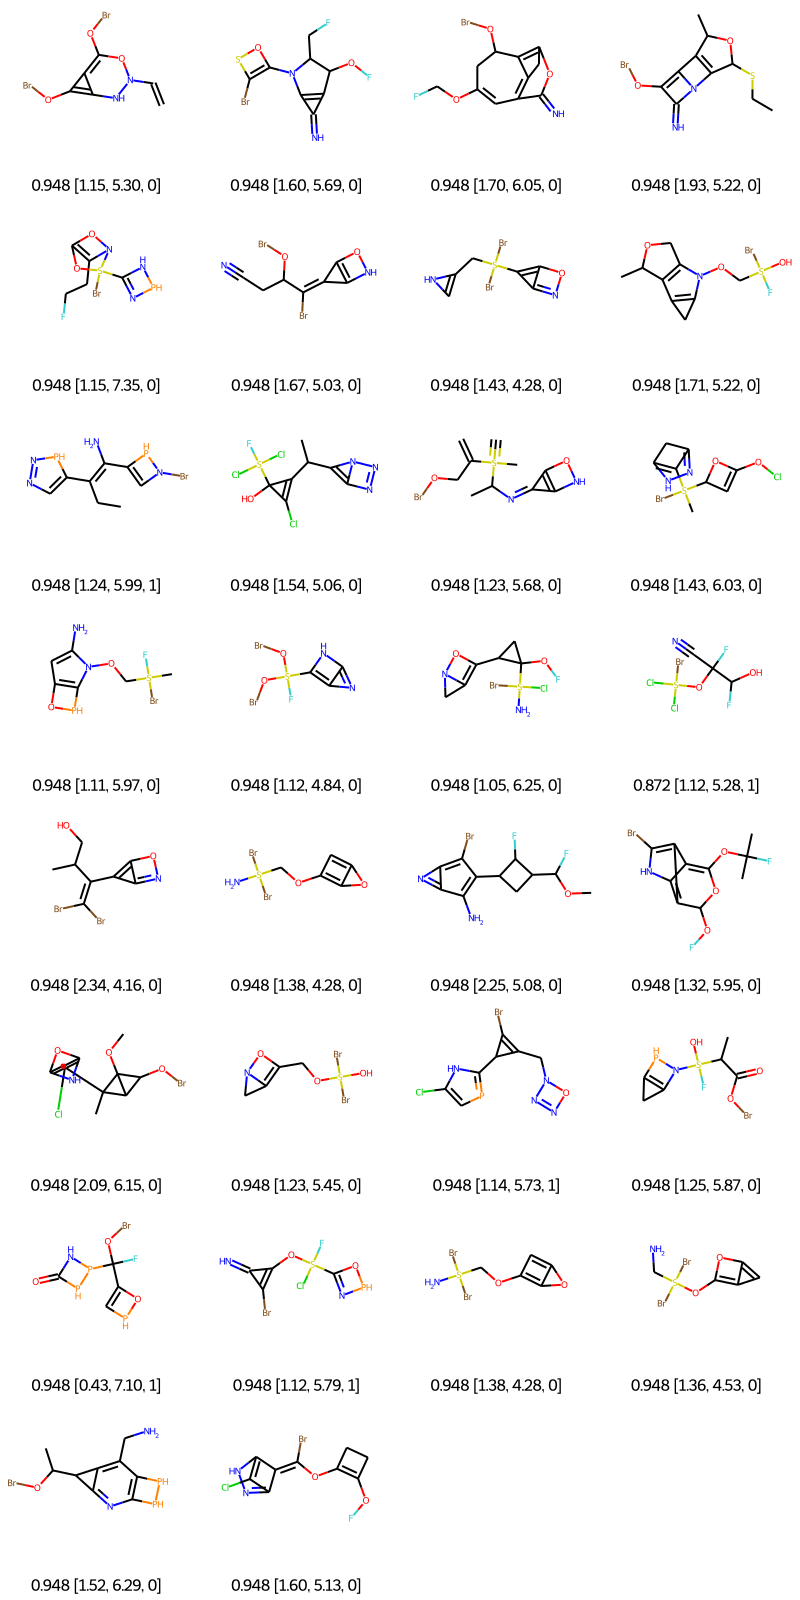

['C=Cn1[nH]c2c(OBr)c-2c(OBr)o1', 'N=c1c2c1N(c1osc1Br)C(CF)C2OF', 'N=c1oc2c3c(c1C=C(OCF)CC3OBr)C2', 'CCSC1OC(C)c2c3c(OBr)c(=N)n-3c21', 'FCCc1c2on1S(Br)(c1n[pH][nH]1)O2', 'N#CCC(OBr)C(Br)=C1c2[nH]oc21', 'BrS(Br)(CC1=CN1)c1c2noc1-2', 'CC1OCc2c1c1c(n2OCS(O)(F)Br)C1', 'CCC(=C(N)c1cn(Br)[pH]1)c1cnn[pH]1', 'CC(C1=C(Cl)C1(O)S(F)(Cl)Cl)c1c2nnn1-2', 'C#S(C)(C(=C)COBr)C(C)N=c1c2[nH]oc12', 'CS(Br)(c1c2n[nH]c1C2)C1C=C(OCl)O1', 'CS(F)(Br)COn1c(N)cc2o[pH]c21', 'FS(OBr)(OBr)c1[nH]c2nc1-2', 'NS(Cl)(Br)C1(OF)CC1c1on2c1C2', 'N#CC(F)(OS(Cl)(Cl)Br)C(O)F', 'CC(CO)C(=C(Br)Br)c1c2noc1-2', 'NS(Br)(Br)COc1cc2oc1-2', 'COC(F)C1CC(c2c(N)c3nc-3c2Br)C1F', 'CC(C)(F)OC1=c2c3[nH]c(Br)c2c3C(OF)O1', 'COC12C(OBr)C1C2(C)c1c(Cl)c2[nH]c1o2', 'OS(Br)(Br)OCc1on2c1C2', 'Clc1cpc(C2C(Br)=C2Cn2nno2)[nH]1', 'CC(C(=O)OBr)S(O)(F)n1[pH]c2c1C2', 'O=c1[nH]p(C(F)(OBr)c2c[pH]o2)[pH]1', 'N=c1c(Br)c1OS(F)(Cl)c1n[pH]o1', 'NS(Br)(Br)COc1cc2oc1-2', 'NCS(Br)(Br)Oc1oc2cc1-2', 'CC(OBr)C1c2nc3[pH][pH]c3c(CN)c21', 'FOC1=C(OC(Br)=c2c3n[nH]c2c3Cl)CC1

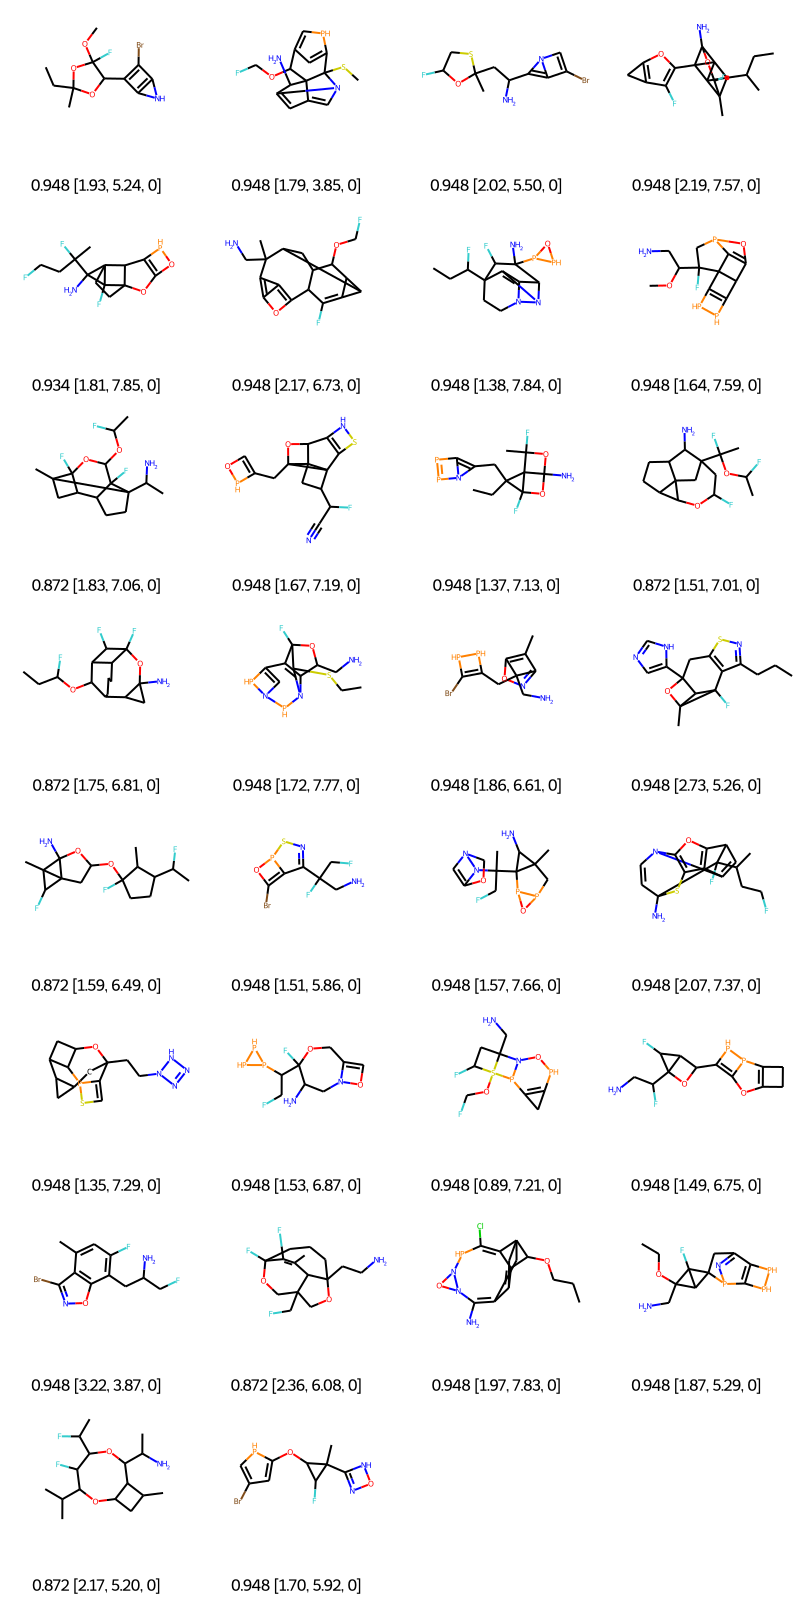

['CCC1(C)OC(c2c(Br)c3[nH]c2=3)C(F)(OC)O1', 'CSC12c3cc(c[pH]3)C(OCF)C13c1cc(n2c1)C3N', 'CC1(CC(N)c2c3c(Br)cn2-3)OC(F)CS1', 'CCC(C)C12C3(C)C(F)OC4(N)C5(c6oc7c(c6F)C7)C41C352', 'CC(F)(CCF)C1(N)C23CCC4(Oc5o[pH]c5C42)C31F', 'CC1(CN)c2c3oc(c2-3)C2C(F)=C3C4C(OCF)C2CC1C34', 'CCC(F)C12CCn3c4c1n3C4C(N)(p1o[pH]1)C2F', 'COC(CN)C1(F)Cp2oc3c2C12c1[pH][pH]c1C32', 'CC(F)OC1OC2(F)C3CC2(C)C2(C(C)N)CCC3C12F', 'N#CC(F)C1CC23C4OC2(Cc2co[pH]2)C13c1s[nH]c14', 'CCC1(Cc2c3ppn2-3)C2(F)OC3(N)OC(C)(F)C312', 'CC(F)OC(C)(F)C12CC(F)OC3C4CCC(C1N)C43C2', 'CCC(F)OC1C2CCCC3C1C(F)C3(F)OC1(N)CC21', 'CCSC1n2[pH]n3cc([pH]3)c3c2C(CN)OC31F', 'Cc1c2noc1C2(CN)Cc1[pH][pH]c1Br', 'CCCc1nsc2c1C1(F)C3C(c4cnc[nH]4)(C2)OC31C', 'CC(F)C1CCC(F)(OC2CC34C(F)C3(C)C4(N)O2)C1C', 'NCC(F)(CF)c1nsp2oc(Br)c12', 'CC12Cp3op3C1(C(C)(CF)n1c3cn1CO3)C2N', 'CC(CCF)C1(F)C2C=c3c4c2oc2c4SC1(N)C=Cn32', 'c1sp2c1C1(CCn3nn[nH]3)CC3CC3C3CC(O1)C32', 'NC1Cn2occ2COC1(F)C(CF)p1[pH][pH]1', 'NCC12CC(F)S1(OCF)p1c3c([pH]on12)C3', 'NCC(F)C12OC(c3[pH]p4c5c(oc34)CC5)C1C2F

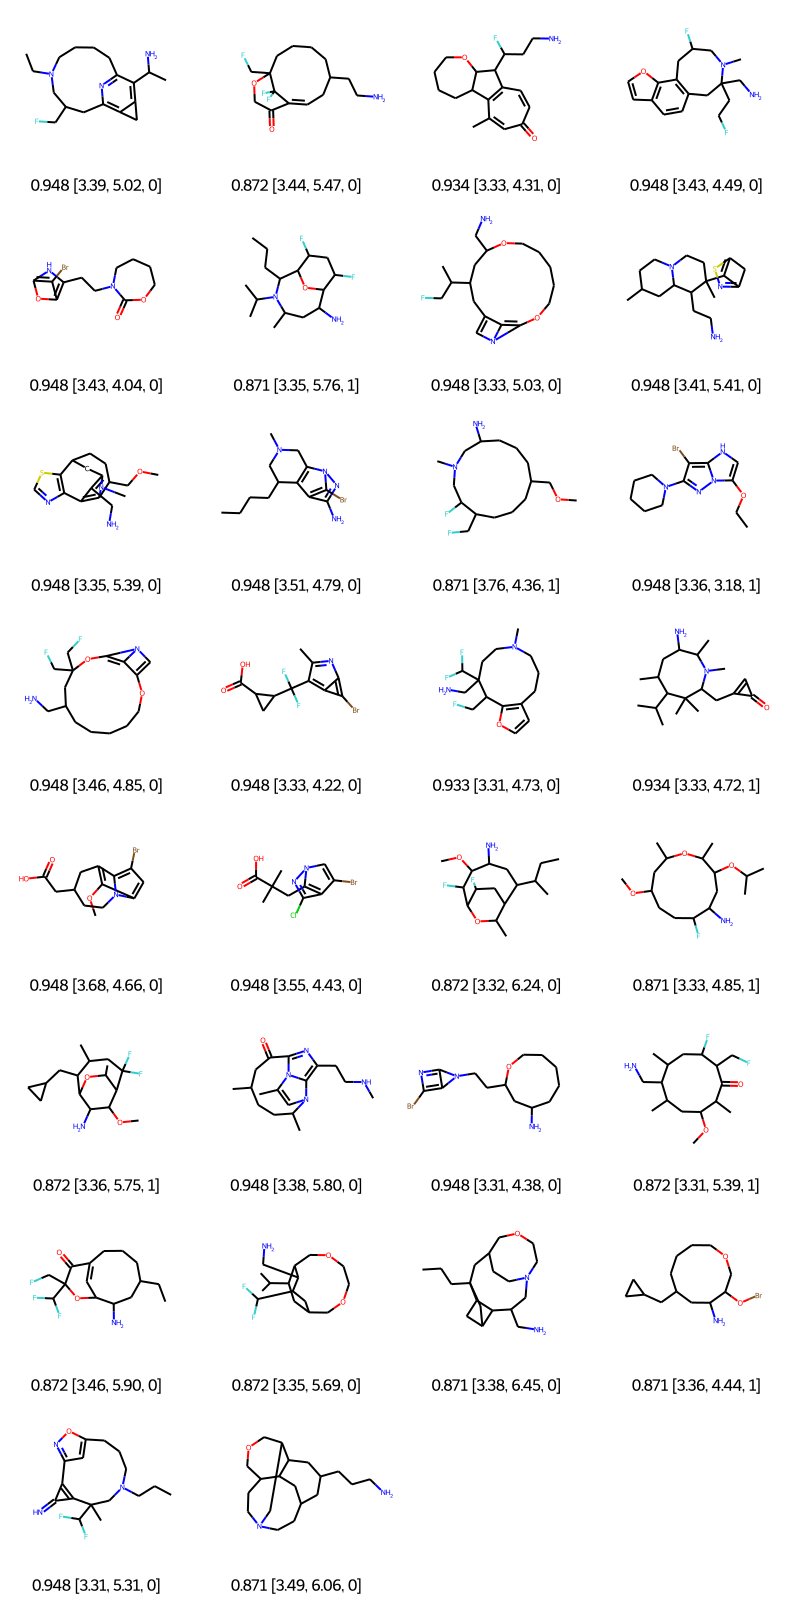

['CCN1CCCCc2nc(c3c(c2C(C)N)C3)CC(CF)C1', 'NCCC1CC=C2C(=O)COC(CF)(CCCC1)C2(F)F', 'Cc1cc(=O)ccc2c1C1CCCCOC1C2C(F)CCN', 'CN1CC(F)Cc2c(ccc3ccoc23)CC1(CN)CCF', 'O=C1OCCCCN1CCc1[nH]c2c(Br)c1O2', 'CCCC1C2OC(C(N)CC(C)N1C(C)C)C(F)CC2F', 'CC(CF)C1Cc2cn3c(c2-3)OCCCCCOC(CN)C1', 'CC1CCN2CCC(C)(c3c4nsc3C4)C(CCN)C2C1', 'COCC1CCC2Cc3c(CN)c(c1n3C)-c1ncsc12', 'CCCCC1CN(C)Cc2c1c1c(N)nn2c1Br', 'COCC1CCCC(N)CN(C)CC(F)C(CF)CCC1', 'CCOc1c[nH]c2c(Br)c(N3CCCCC3)nn12', 'NCC1CCCCCOc2cn3c(c2-3)OC(CF)(CF)C1', 'Cc1nc2c(Br)c-2c1C(F)(F)C1CC1C(=O)O', 'CN1CCCc2ccoc2C(CF)C(CN)(C(F)F)CC1', 'CC(C)C1C(C)CC(N)C(C)N(C)C(Cc2cc2=O)C1(C)C', 'COc1c2c3c(Br)cc1n3CCC(CC(=O)O)C2', 'CC(C)(Cc1c2c(Br)cn1nc2Cl)C(=O)O', 'CCC(C)C1CC(N)C(OC)C(F)C2OC(C)C1CC2F', 'COC1CCC(F)C(N)CC(OC(C)C)C(C)OC(C)C1', 'COC1C(N)C2OC(C)C1C(F)(F)CC(C)C2CC1CC1', 'CNCCc1nc2n3c(C)cn(c13)C(C)CCC(C)CC2=O', 'NC1CCCCCOC(CCn2c3nc(Br)c2-3)C1', 'COC1CC(C)C(CN)C(C)CC(F)C(CF)C(=O)C1C', 'CCC1CCCC2=CC(OC(CF)(C(F)F)C2=O)C(N)C1', 'CC(C)C1CC2COCCOCC1C(CN)C(C(F)F)C2', 'CCCC12CC3C

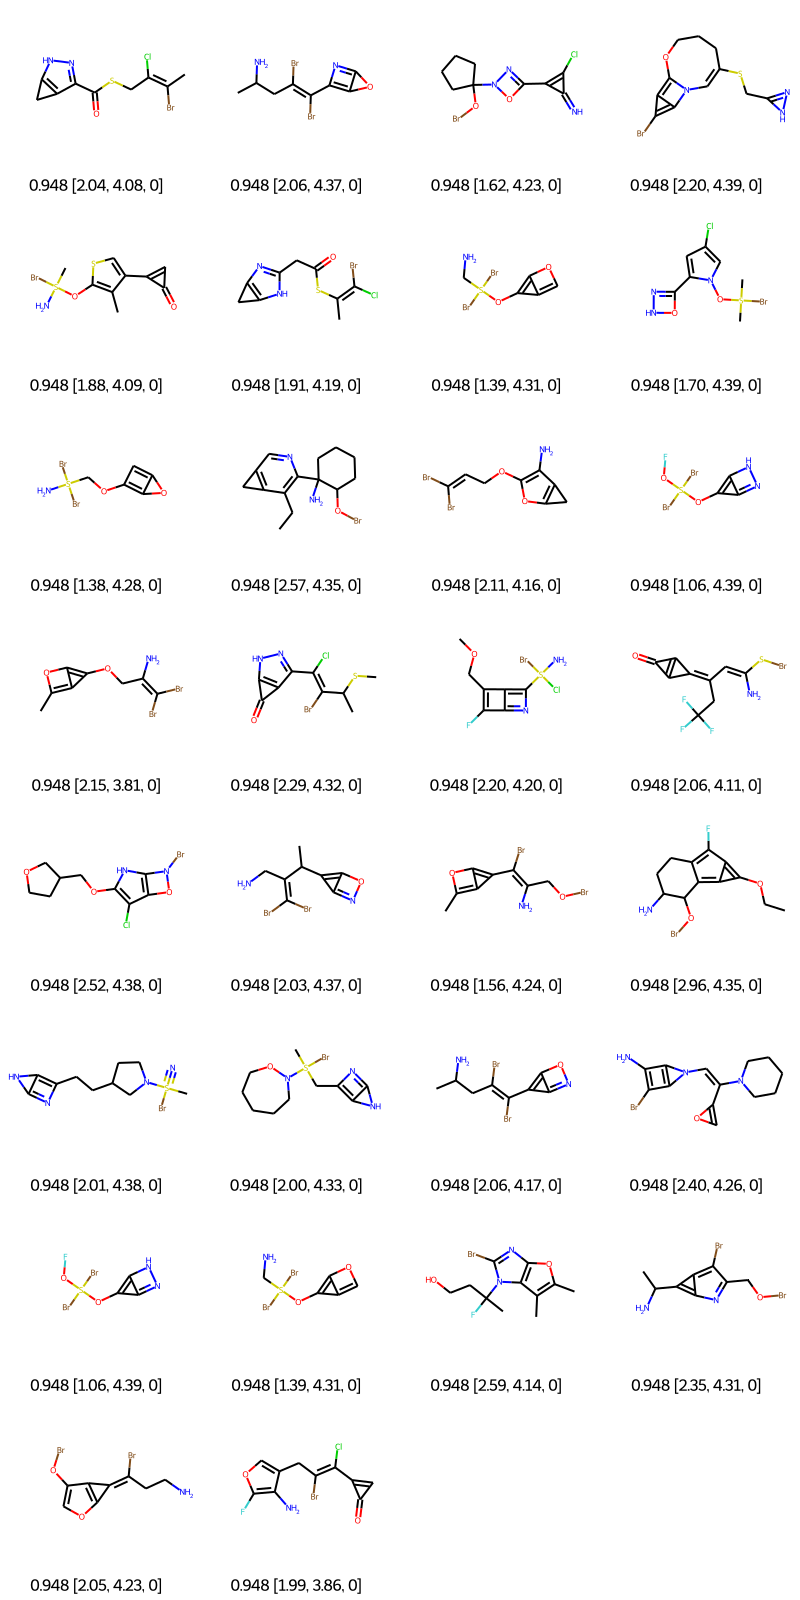

['CC(Br)=C(Cl)CSC(=O)c1n[nH]c2c1C2', 'CC(N)CC(Br)=C(Br)c1nc2oc1-2', 'N=c1c(Cl)c1-c1nn(C2(OBr)CCCC2)o1', 'Brc1c2c3n(c1-2)C=C(SCC1=NN1)CCCO3', 'Cc1c(-c2cc2=O)csc1OS(C)(N)Br', 'CC(SC(=O)Cc1nc2c([nH]1)C2)=C(Cl)Br', 'NCS(Br)(Br)Oc1c2coc1-2', 'CS(C)(Br)On1cc(Cl)cc1-c1n[nH]o1', 'NS(Br)(Br)COc1cc2oc1-2', 'CCc1c(C2(N)CCCCC2OBr)ncc2c1C2', 'Nc1c(OCC=C(Br)Br)oc2c1C2', 'FOS(Br)(Br)Oc1c2n[nH]c1-2', 'Cc1oc2c(OCC(N)=C(Br)Br)c1-2', 'CSC(C)C(Br)=C(Cl)c1n[nH]c2c(=O)c12', 'COCc1c(F)c2nc(S(N)(Cl)Br)c1-2', 'NC(=CC(CC(F)(F)F)=C1c2c1c2=O)SBr', 'Clc1c(OCC2CCOC2)[nH]c2c1on2Br', 'CC(C(CN)=C(Br)Br)c1c2noc1-2', 'Cc1oc2c(C(Br)=C(N)COBr)c1-2', 'CCOc1c2c(F)c3c(c1-2)C(OBr)C(N)CC3', 'CS(#N)(Br)N1CCC(CCc2nc3[nH]c2-3)C1', 'CS(Br)(Cc1nc2[nH]c1-2)N1CCCCCO1', 'CC(N)CC(Br)=C(Br)c1c2noc1-2', 'Nc1c(Br)c2n(C=C(C3=CO3)N3CCCCC3)c1=2', 'FOS(Br)(Br)Oc1c2n[nH]c1-2', 'NCS(Br)(Br)Oc1c2coc1-2', 'Cc1oc2nc(Br)n(C(C)(F)CCO)c2c1C', 'CC(N)c1c2nc(COBr)c(Br)c1-2', 'NCCC(Br)=C1c2occ(OBr)c21', 'Nc1c(CC(Br)=C(Cl)c2cc2=O)coc1F']


['CCC1CC2C(CC3OC(C(C)CC)C3O1)C1C3C(N)C2C31', 'NC1CCCC(c2cc3nc-3c2)N(CC=CBr)C1', 'NC1CCC2CC(=O)C(CCCF)=C2CCOCC1(F)F', 'NC1CCc2c3cc-3nc2N(CCC=CBr)CC1', 'C=C(Cl)CN1CC2Cc3nc(-c4cc[nH]n4)sc3CC21', 'Cc1nc2c3c(ccc2[nH]1)OC(OCC=CBr)C3', 'NCC1CC2C(C=CCl)C2CC(c2cc2=O)CC2=C(C2)O1', 'NCC1(F)CCCOC(C(F)F)CC(c2cc2=O)CCC1', 'C=C(Cl)CN1CC(C)CCc2c(cc3nc2-3)CC(CN)C1', 'COC1CC2OC3CC4C(CC(CC(C)N)CC4C12)C1CC31', 'Cc1[nH]c2nnncc2c1CCC=C(Cl)Br', 'CN1CCCC(CF)CCCOCCCC(CN)(CF)C1', 'CN1CCCCC(CF)CC(N)CC(CCF)COCC1', 'ClC=CCOC1Cc2[nH]nc3c2CCc2nc-3sc2C1', 'CCOc1nc2c(C=CBr)csc2c(=O)[nH]1', 'CC1CCC(N)C(OCC=CBr)C(C)OC1C', 'CN1CCc2oc(CCCN)cc2Cc2ccsc2CC1', 'CCOc1nc2c(C=CBr)csc2c(=O)[nH]1', 'O=C(O)COc1c(Br)c2cc-2c1Br', 'COC1CC(C)CCC(C(C)N)OC1C=CBr', 'O=C(NCC=CBr)Oc1c2c3cc(c1-2)COCC3', 'NC1CCC2C(CCc3cc3=O)C2COC=CCCCC1F', 'FCCCc1n[nH]c2cc3c(cc12)CCCOCCOCC3', 'NC1CCC(C=CBr)CN(Cc2cc3c(o2)C3)C1', 'Cc1cc2nc(OCC=CBr)[nH]c(=O)c2s1', 'CC(C)CCc1nc2nc(Br)sc2c(=O)[nH]1', 'CC(F)COC1C(C)CCC2CC(F)C(N)COC2C1C', 'CC1CN(C(C)C)CC(N)C(F)CC2C3

In [10]:
plot_solutions(models)